In [3]:
import cv2
import numpy as np

# Load image with alpha channel
img = cv2.imread('/home/suyeonchoi/Infrared_apriltag_detection/gen_syn_img/TagCustom52h12/tag52_12_00001.png', cv2.IMREAD_UNCHANGED)  # This loads as BGRA


# Check for alpha channel
if img.shape[2] == 4:
    # Split channels
    b, g, r, a = cv2.split(img)

    # Create white background
    white_bg = np.ones_like(a, dtype=np.uint8) * 255

    # Normalize alpha to range 0.0 - 1.0
    alpha_norm = a.astype(float) / 255

    # Composite over white
    b = b * alpha_norm + white_bg * (1 - alpha_norm)
    g = g * alpha_norm + white_bg * (1 - alpha_norm)
    r = r * alpha_norm + white_bg * (1 - alpha_norm)

    # Merge back without alpha
    result = cv2.merge([b.astype(np.uint8), g.astype(np.uint8), r.astype(np.uint8)])
    result = cv2.resize(result, (100, 100), interpolation=cv2.INTER_NEAREST)

    # Save result
    cv2.imwrite('template.jpg', result)
else:
    print("Image does not have an alpha channel.")

In [5]:
# Siamese Network for Template Matching
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as T


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Lightweight encoder (e.g., pre-trained ResNet18 backbone, or custom CNN)
        resnet = models.resnet18(weights=None)  # You can load pretrained weights if needed
        resnet.fc = nn.Identity()  # remove final classification layer
        self.encoder = resnet

    def forward_once(self, x):
        return self.encoder(x)

    def forward(self, x1, x2):
        # Encode both template and search image
        feat1 = self.forward_once(x1)  # shape: [B, D]
        feat2 = self.forward_once(x2)  # shape: [B, D]
        # Compute cosine similarity
        similarity = F.cosine_similarity(feat1, feat2, dim=1)
        return similarity  # higher means more similar



model = SiameseNetwork()

# Simulate grayscale images with batch size = 1, convert to 3 channels
template = cv2.imread('datasets/template.jpg', cv2.IMREAD_GRAYSCALE)
search = cv2.imread('datasets/boson6/origs/train/Apr1_148.jpg', cv2.IMREAD_GRAYSCALE)
template_img = cv2.resize(template, (128, 128))
search_img = cv2.resize(search, (256, 256))

template_img = cv2.cvtColor(template_img, cv2.COLOR_GRAY2RGB)
search_img = cv2.cvtColor(search_img, cv2.COLOR_GRAY2RGB)    # template = torch.randn(1, 3, 128, 128)  # Replace with actual image
# search = torch.randn(1, 3, 128, 128)

transform = T.Compose([
    T.ToTensor(),  # Converts to [C, H, W] and scales to [0, 1]
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1]
])

# Apply transforms
template_tensor = transform(template_img).unsqueeze(0)  # [1, 3, 128, 128]
search_tensor = transform(search_img).unsqueeze(0)

# Move to same device as model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
template_tensor = template_tensor.to(device)
search_tensor = search_tensor.to(device)

# Forward pass
model.eval()
with torch.no_grad():
    similarity = model(template_tensor, search_tensor)
    print("Similarity:", similarity.item())

Similarity: 0.9695367217063904


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        resnet = models.resnet18(weights=None)
        resnet.fc = nn.Identity()  # Remove classification layer

        # Keep everything up to the last conv layer (remove avgpool and FC)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: [B, 512, H/32, W/32]

    def extract_features(self, x):
        return self.encoder(x)

    def forward(self, template, search):
        z = self.extract_features(template)  # [1, C, kh, kw]
        x = self.extract_features(search)    # [1, C, h, w]

        kernel = z.squeeze(0).unsqueeze(1)   # [C, 1, kh, kw]
        response = F.conv2d(x, kernel, groups=x.shape[1])  # [1, C, H, W]

        # ✅ sum across channels, not batch or spatial
        out = response.sum(dim=1, keepdim=True)  # [1, 1, H, W]
        return out

In [8]:
# Load images (grayscale)
template = cv2.imread('datasets/template.jpg', cv2.IMREAD_GRAYSCALE)
search = cv2.imread('datasets/boson6/origs/train/Apr1_148.jpg', cv2.IMREAD_GRAYSCALE)

# Convert to 3 channels
template_rgb = cv2.cvtColor(template, cv2.COLOR_GRAY2RGB)
search_rgb = cv2.cvtColor(search, cv2.COLOR_GRAY2RGB)

# Transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
template_tensor = transform(template_rgb).unsqueeze(0).to(device)
search_tensor = transform(search_rgb).unsqueeze(0).to(device)

# Run model
model = SiameseNetwork().to(device)
model.eval()
with torch.no_grad():
    heatmap = model(template_tensor, search_tensor)  # [1, 1, 17, 13]
    heatmap = heatmap.squeeze(0).squeeze(0).cpu().numpy()

# Find best match
y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)

# Map back to pixel location in original image
stride = 32  # ResNet downsampling factor
x_px = int(x * stride)
y_px = int(y * stride)
print(f"Match in search image: ({x_px}, {y_px})")


Match in search image: (480, 160)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        resnet = models.resnet18(weights=None)

        # Modify first conv layer to accept 1-channel input instead of 3
        resnet.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=resnet.conv1.out_channels,
            kernel_size=resnet.conv1.kernel_size,
            stride=resnet.conv1.stride,
            padding=resnet.conv1.padding,
            bias=resnet.conv1.bias is not None,
        )

        resnet.fc = nn.Identity()  # Remove classification head
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Up to conv layers

    def extract_features(self, x):
        return self.encoder(x)  # [B, 512, H/32, W/32]

    def forward(self, template, search):
        z = self.extract_features(template)  # [1, 512, kh, kw]
        x = self.extract_features(search)    # [1, 512, H, W]

        kernel = z.squeeze(0).unsqueeze(1)   # [512, 1, kh, kw]
        response = F.conv2d(x, kernel, groups=x.shape[1])  # [1, 512, H-kh+1, W-kw+1]
        out = response.sum(dim=1, keepdim=True)  # [1, 1, H_out, W_out]
        return out


Match in search image: (480, 160)


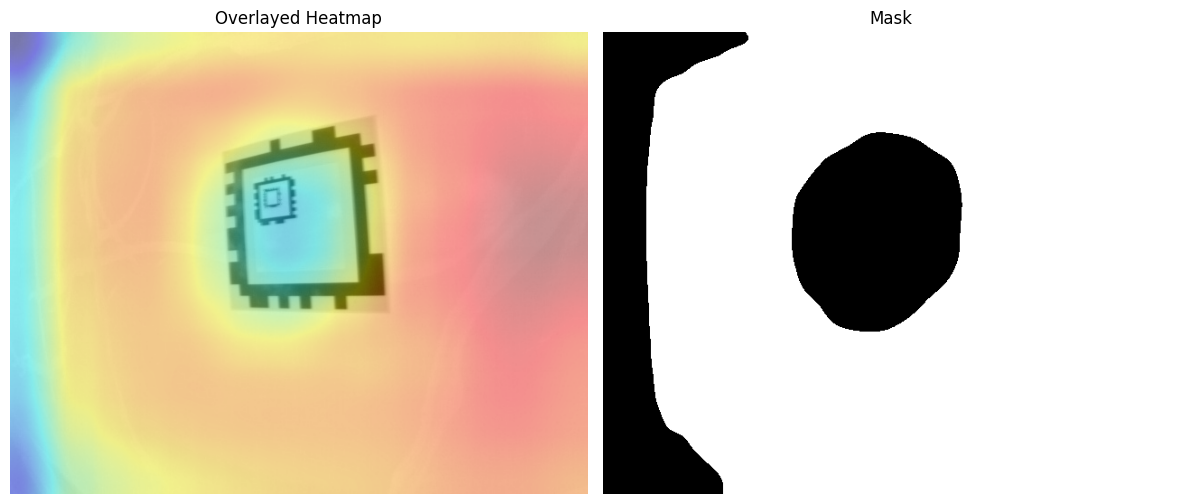

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


transform = T.Compose([
    T.ToTensor(),  # Converts to [1, H, W] for grayscale
    T.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale
])

template = cv2.imread('datasets/template.jpg', cv2.IMREAD_GRAYSCALE)
search = cv2.imread('datasets/boson6/origs/train/Apr1_148.jpg', cv2.IMREAD_GRAYSCALE)

template_tensor = transform(template).unsqueeze(0).to(device)  # [1, 1, 128, 128]
search_tensor = transform(search).unsqueeze(0).to(device)      # [1, 1, 512, 640]

# Run model
model = SiameseNetwork().to(device)
model.eval()
with torch.no_grad():
    heatmap = model(template_tensor, search_tensor)  # [1, 1, 17, 13]
    heatmap = heatmap.squeeze(0).squeeze(0).cpu().numpy()

# Find best match
y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)

# Map back to pixel location in original image
stride = 32  # ResNet downsampling factor
x_px = int(x * stride)
y_px = int(y * stride)
print(f"Match in search image: ({x_px}, {y_px})")


# Step 1: Resize heatmap to original image size
heatmap_resized = cv2.resize(
    heatmap, 
    (search.shape[1], search.shape[0]),  # (width, height)
    interpolation=cv2.INTER_CUBIC
)

# Step 2: Normalize and convert to color
heatmap_norm = cv2.normalize(heatmap_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)  # shape: [H, W, 3]

# Step 3: Ensure original search image is 3-channel
if len(search.shape) == 2:
    search_bgr = cv2.cvtColor(search, cv2.COLOR_GRAY2BGR)
else:
    search_bgr = search.copy()

# Step 4: Overlay heatmap on original image
overlay = cv2.addWeighted(search_bgr, 0.6, heatmap_color, 0.4, 0)

_, heat_mask = cv2.threshold(heatmap_norm, 150, 255, cv2.THRESH_BINARY)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Example image placeholders (replace with actual image arrays)
# overlay1 = ...
# overlay2 = ...

axes[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axes[0].set_title("Overlayed Heatmap")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(heat_mask, cv2.COLOR_BGR2RGB))
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
from tqdm import tqdm  # for progress bar

# --- CONFIG ---
input_dir  = "datasets/boson9/origs/train"
output_dir = "datasets/boson9/heatmap"
mask_dir   = "datasets/boson9/mask"
template_path = "template.png"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# --- PREPARE MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
model.eval()

# --- PREPARE TRANSFORM ---
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

# --- LOAD TEMPLATE ONCE ---
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
template_tensor = transform(template).unsqueeze(0).to(device)  # [1, 1, 128, 128]

# --- PROCESS EACH SEARCH IMAGE ---
for filename in tqdm(sorted(os.listdir(input_dir))):
    if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    search_path = os.path.join(input_dir, filename)
    search = cv2.imread(search_path, cv2.IMREAD_GRAYSCALE)

    if search is None:
        print(f"Failed to load {search_path}")
        continue

    search_tensor = transform(search).unsqueeze(0).to(device)  # [1, 1, H, W]

    with torch.no_grad():
        heatmap = model(template_tensor, search_tensor)  # [1, 1, Hc, Wc]
        heatmap = heatmap.squeeze(0).squeeze(0).cpu().numpy()

    # Resize heatmap to original image size
    heatmap_resized = cv2.resize(
        heatmap,
        (search.shape[1], search.shape[0]),  # (width, height)
        interpolation=cv2.INTER_CUBIC
    )

    # Normalize and colorize
    heatmap_norm = cv2.normalize(heatmap_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    # Convert grayscale to BGR
    if len(search.shape) == 2:
        search_bgr = cv2.cvtColor(search, cv2.COLOR_GRAY2BGR)
    else:
        search_bgr = search.copy()

    # Overlay heatmap
    overlay = cv2.addWeighted(search_bgr, 0.6, heatmap_color, 0.4, 0)

    # Save to output directory
    out_path = os.path.join(output_dir, filename)
    cv2.imwrite(out_path, overlay)

    # Normalize to 0–255
    heatmap_norm = cv2.normalize(heatmap_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Threshold the heatmap — you can tune 80 here (0–255 scale)
    _, heat_mask = cv2.threshold(heatmap_norm, 180, 255, cv2.THRESH_BINARY)

    # Save mask as single-channel PNG (use same name pattern)
    mask_path = os.path.join(mask_dir, filename)
    cv2.imwrite(mask_path, heat_mask)

100%|██████████| 874/874 [00:05<00:00, 147.52it/s]


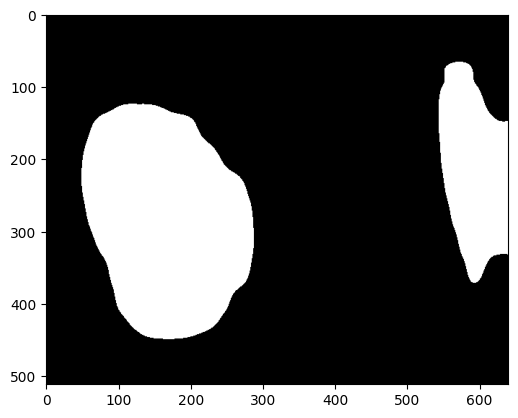

In [8]:
plt.imshow(heat_mask, cmap='gray')

In [2]:
from skimage import io, filters, feature, color
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm

# folder_name = ['Apr1_2025/day_traj', 'Jul3_2025/day_hover1', 'Jul3_2025/day_hover2', 'Jul3_2025/day_traj1', 'Jul3_2025/day_traj2', 'Jul3_2025/day_updown',
#                'Jul3_2025/night_hover1', 'Jul3_2025/night_hover2', 'Jul3_2025/night_traj1', 'Jul3_2025/night_traj2', 'Jul3_2025/night_updown', 
#                'Jun27_2025/night_hover1', 'Jun27_2025/night_hover2', 'Jun27_2025/night_traj',
#                'Jun27_2025/night_updown', 'May31_2025/day_hover1', 'May31_2025/day_hover2', 'May31_2025/day_hover3']

# for i in range(len(folder_name)):

    # input_dir  = f"datasets/drone2/{folder_name[i]}/image"
    # mask_dir   = f"datasets/drone2/{folder_name[i]}/mask"

input_dir  = "datasets/pix2pix_test/image"
mask_dir   = "datasets/pix2pix_test/mask"


os.makedirs(mask_dir, exist_ok=True)

for filename in tqdm(sorted(os.listdir(input_dir))):
    search_path = os.path.join(input_dir, filename)
    search = cv2.imread(search_path, cv2.IMREAD_GRAYSCALE)
    edges = feature.canny(search, sigma=2.0).astype(np.uint8) * 255

    kernel = np.ones((70, 70), dtype=np.uint8)  # You can change size for thickness
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Step 3: Convert to binary mask (0 or 255)
    mask = (dilated_edges > 0).astype(np.uint8) * 255

    mask_path = os.path.join(mask_dir, filename)
    cv2.imwrite(mask_path, mask)


100%|██████████| 2400/2400 [00:31<00:00, 76.80it/s]


In [ ]:
import math
import cv2
import numpy as np
import os

ori_dir       = 'datasets/drone/Apr1_2025/day_traj/img_8bit'
rectified_dir = 'datasets/drone/Apr1_2025/day_traj/img_8bit_rect'


os.makedirs(rectified_dir, exist_ok=True)

fov_deg = 90
fov_rad = math.radians(fov_deg)

focal_length_mm = 4.9
sensor_width_mm = 12.8

for filename in os.listdir(ori_dir):
    filepath = os.path.join(ori_dir, filename)
    new_filepath = os.path.join(rectified_dir, filename)
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    image_height, image_width = img.shape[:2]

    focal_length = (focal_length_mm * image_width) / sensor_width_mm

    cx = image_width / 2
    cy = image_height / 2

    K = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ])

    D = np.array([-0.04, 0, 0, 0, 0])

    map1, map2 = cv2.initUndistortRectifyMap(K, D, None, K, (image_width, image_height), cv2.CV_32FC1)

    undistorted = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR)

    cv2.imwrite(new_filepath, undistorted)


In [3]:
import os
import shutil

# === Configuration ===
source_dir = "datasets/boson11/images/train"
target_dir = "datasets/pix2pix_train5/synthesized/train"
prefix = "synthetic_"  # New filename prefix

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Get list of files
files = sorted(f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)))

# Process and rename
for i, filename in enumerate(files):
    name, ext = os.path.splitext(filename)
    new_name = f"{prefix}_{name}{ext}"
    
    src_path = os.path.join(source_dir, filename)
    dst_path = os.path.join(target_dir, new_name)

    shutil.copy2(src_path, dst_path)  # Use shutil.move(...) if you want to move instead

    print(f"Copied {filename} -> {new_name}")


Copied Apr1_148.jpg -> synthetic__Apr1_148.jpg
Copied Apr1_148_180.jpg -> synthetic__Apr1_148_180.jpg
Copied Apr1_148_270.jpg -> synthetic__Apr1_148_270.jpg
Copied Apr1_148_90.jpg -> synthetic__Apr1_148_90.jpg
Copied Apr1_155.jpg -> synthetic__Apr1_155.jpg
Copied Apr1_155_180.jpg -> synthetic__Apr1_155_180.jpg
Copied Apr1_155_270.jpg -> synthetic__Apr1_155_270.jpg
Copied Apr1_155_90.jpg -> synthetic__Apr1_155_90.jpg
Copied Apr1_156.jpg -> synthetic__Apr1_156.jpg
Copied Apr1_156_180.jpg -> synthetic__Apr1_156_180.jpg
Copied Apr1_156_270.jpg -> synthetic__Apr1_156_270.jpg
Copied Apr1_156_90.jpg -> synthetic__Apr1_156_90.jpg
Copied Apr1_158.jpg -> synthetic__Apr1_158.jpg
Copied Apr1_158_180.jpg -> synthetic__Apr1_158_180.jpg
Copied Apr1_158_270.jpg -> synthetic__Apr1_158_270.jpg
Copied Apr1_158_90.jpg -> synthetic__Apr1_158_90.jpg
Copied Apr1_159.jpg -> synthetic__Apr1_159.jpg
Copied Apr1_159_180.jpg -> synthetic__Apr1_159_180.jpg
Copied Apr1_159_270.jpg -> synthetic__Apr1_159_270.jpg
Cop

In [2]:
import os

folder_name = ['Apr1_2025/day_traj', 'Jul3_2025/day_hover1', 'Jul3_2025/day_hover2', 'Jul3_2025/day_traj1', 'Jul3_2025/day_traj2', 'Jul3_2025/day_updown',
               'Jul3_2025/night_hover1', 'Jul3_2025/night_hover2', 'Jul3_2025/night_traj1', 'Jul3_2025/night_traj2', 'Jul3_2025/night_updown', 
               'Jun27_2025/night_hover1', 'Jun27_2025/night_hover2', 'Jun27_2025/night_traj',
               'Jun27_2025/night_updown', 'May31_2025/day_hover1', 'May31_2025/day_hover2', 'May31_2025/day_hover3']

for i in range(len(folder_name)):
    folder = f'datasets/drone2/{folder_name[i]}'

    os.makedirs(folder, exist_ok=True)

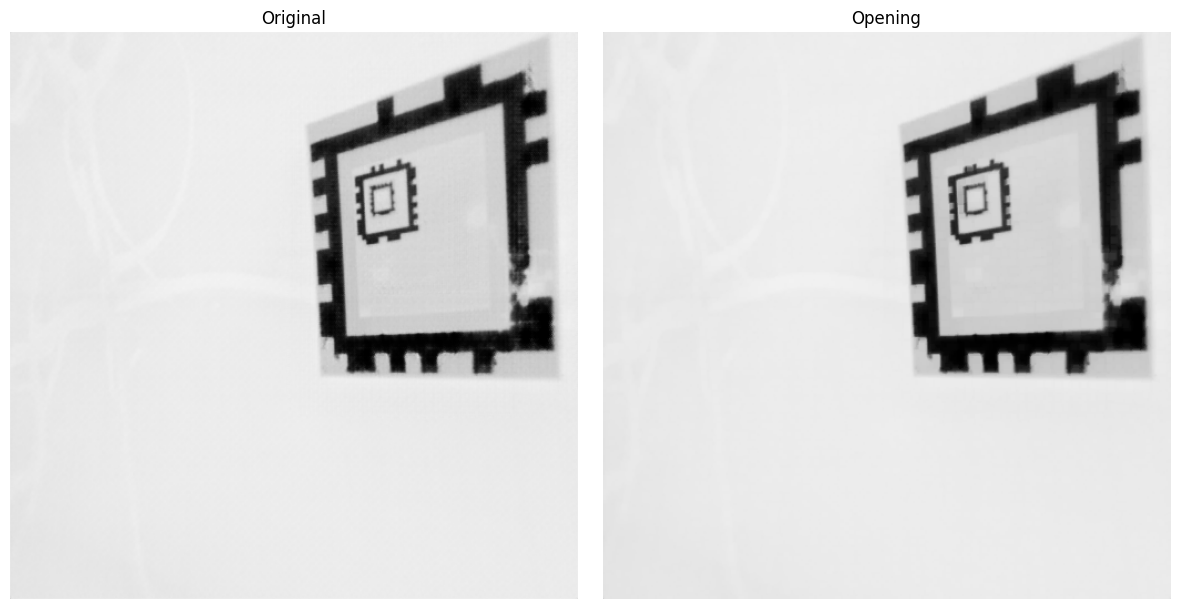

In [10]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

kernel = np.ones((5, 5), np.uint8)

img = cv2.imread('datasets/drone2/Apr1_2025/day_traj/result_full_mask2/Apr1_2025_day_traj_312799000000_fake.png')
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(opening, cv2.COLOR_BGR2RGB))
axes[1].set_title("Opening")
axes[1].axis("off")

plt.tight_layout()
plt.show()